*Final Project Mata Kuliah Pengolahan Citra Digital dan Visi Komputer*

# **BISINDO-Smart: Penerjemah Bahasa Isyarat Indonesia (BISINDO) Real-Time Menggunakan Pelacakan Tangan Berbasis Operasi Morfologi dan Klasifikasi MobileNetV2**


- Anggota Kelompok	:
  1. Muhammad Hasan Fadhlillah - 225150207111026
	2. Muhammad Husain Fadhlillah - 225150207111027

- Mata Kuliah		: Pengolahan Citra Digital dan Visi Komputer

- Kelas			: A

- Dosen Pengampu	:
  - Ibu Yuita Arum Sari, S.Kom., M.Kom., Ph. D.
  - Ibu Dr. Eng. Irawati Nurmala Sari, S.Kom., M.Sc.


**📘 Tujuan Notebook**

Notebook ini berfungsi sebagai "Pabrik Model AI" (Training Pipeline) untuk project BISINDO-Smart. Di sini, kita tidak menjalankan aplikasi real-time (seperti webcam), melainkan fokus pada proses "belajar" komputer: mulai dari mengunduh ribuan gambar gestur tangan (Dataset), membersihkannya (Preprocessing), melatih otak buatan (MobileNetV2), hingga menyimpan hasilnya menjadi file model (.h5, .keras, .tflite) yang siap dipakai di aplikasi lain (app.py atau main.py).

# **Load & Data Preparataion 📦**

In [1]:
!pip install kagglehub -q
import kagglehub
import os

print("⬇️ Mendownload Dataset BISINDO...")
path = kagglehub.dataset_download("agungmrf/indonesian-sign-language-bisindo")
print(f"✅ Dataset ada di sistem: {path}")

def find_real_image_dir(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'A' in dirs:
            path_a = os.path.join(root, 'A')
            files_in_a = os.listdir(path_a)

            if len(files_in_a) > 0:
                first_file = files_in_a[0].lower()
                if first_file.endswith(('.jpg', '.jpeg', '.png')):
                    if 'train' in root.lower():
                        return root
    return None

data_dir = find_real_image_dir(path)

if data_dir:
    print(f"📂 Folder GAMBAR (TRAIN) Ditemukan di: {data_dir}")
    sample_a = os.path.join(data_dir, 'A')
    list_files = os.listdir(sample_a)
    count = len(list_files)
    print(f"📊 Verifikasi: Folder 'A' berisi {count} file.")
    print(f"🧐 Contoh file: {list_files[:3]}")

    os.environ['DATA_DIR_FIXED'] = data_dir
else:
    print("❌ ERROR: Folder gambar tidak ditemukan!")

⬇️ Mendownload Dataset BISINDO...


100%|██████████| 1.36G/1.36G [00:13<00:00, 111MB/s]

Extracting files...


✅ Dataset ada di sistem: /root/.cache/kagglehub/datasets/agungmrf/indonesian-sign-language-bisindo/versions/1
📂 Folder GAMBAR (TRAIN) Ditemukan di: /root/.cache/kagglehub/datasets/agungmrf/indonesian-sign-language-bisindo/versions/1/bisindo/images/train
📊 Verifikasi: Folder 'A' berisi 350 file.
🧐 Contoh file: ['augmented_image_42.jpg', 'flip091.jpg', 'rotate002.jpg']


Disini kita **mengunduh dataset mentah** langsung dari Kaggle menggunakan library kagglehub tanpa perlu upload manual. Karena struktur folder di Kaggle seringkali berantakan (banyak sub-folder), fungsi find_real_image_dir dibuat cerdas untuk "berburu" folder yang benar-benar berisi gambar (mencari folder bernama 'A' di dalam folder 'train'). Kode berhasil menemukan lokasi dataset yang valid di /root/.cache/.../train dan memverifikasi bahwa folder 'A' berisi 350 gambar, menandakan data siap diolah.

# **Preparation & Data Augementation 🔄**

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

if 'DATA_DIR_FIXED' in os.environ:
    data_dir = os.environ['DATA_DIR_FIXED']
print(f"⚙️ Menggunakan folder: {data_dir}")

IMG_SIZE = (128, 128) # Resolusi input ke model
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalisasi (0-255 jadi 0-1)
    rotation_range=20,      # Rotasi tangan (biar kenal tangan miring)
    width_shift_range=0.2,  # Geser posisi
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2], # Simulasi cahaya terang/gelap
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,  # TIDAK DI FLIP (Arah tangan SIBI itu spesifik)
    fill_mode='nearest',
    validation_split=0.2    # 20% data untuk Validasi (Ujian)
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

if train_generator.n > 0:
    class_labels = list(train_generator.class_indices.keys())
    print(f"✅ Label Kelas Siap ({len(class_labels)}): {class_labels}")

⚙️ Menggunakan folder: /root/.cache/kagglehub/datasets/agungmrf/indonesian-sign-language-bisindo/versions/1/bisindo/images/train
Found 7342 images belonging to 26 classes.
Found 1827 images belonging to 26 classes.
✅ Label Kelas Siap (26): ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


Disini kita menyiapkan pi**peline data otomatis** menggunakan ImageDataGenerator. Kita melakukan **Augmentasi Data** (memutar, menggeser, zoom gambar secara acak) agar model lebih pintar mengenali tangan meski posisinya tidak sempurna. Penting dicatat: horizontal_flip=False karena tangan kiri dan kanan di bahasa isyarat punya arti beda. Sistem berhasil membagi data menjadi **7.342 gambar untuk latihan (training)** dan **1.827 gambar untuk ujian (validation)**, serta mengenali **26 kelas huruf (A-Z)**.

# **Membangun Model MobileNetV2 (Transfer Learning) 🧠**

In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers, Input

inputs = Input(shape=(128, 128, 3))
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=inputs)

# Bekukan layer awal
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

# Rangkai Model (Functional API Style)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(len(class_labels), activation='softmax')(x)

model = models.Model(inputs, outputs)
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/tmp/ipython-input-1557223653.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=inputs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,592,602 (9.89 MB)

 Trainable params: 2,016,154 (7.69 MB)

 Non-trainable params: 576,448 (2.20 MB)

Disini kita membangun arsitektur otak AI menggunakan teknik **Transfer Learning** dengan **MobileNetV2**. Kita "meminjam" otak MobileNet yang sudah pintar mengenali benda umum (pre-trained ImageNet), lalu membuang bagian kepalanya (include_top=False) dan menggantinya dengan layer baru yang khusus mengenali 26 huruf BISINDO. Kita juga "membekukan" sebagian besar layer lama agar tidak rusak saat latihan, hanya 40 layer terakhir yang dilatih ulang (fine-tuning). Model memiliki total **2,5 juta parameter**, di mana sekitar 2 juta parameter akan kita latih agar spesifik mengenali tangan kita.

# **Training Model**

Epoch 1/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 129s 481ms/step - accuracy: 0.3016 - loss: 2.6554 - val_accuracy: 0.8582 - val_loss: 0.4184
Epoch 2/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 75s 326ms/step - accuracy: 0.7418 - loss: 0.9097 - val_accuracy: 0.9699 - val_loss: 0.0975
Epoch 3/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 75s 328ms/step - accuracy: 0.8374 - loss: 0.5461 - val_accuracy: 0.9863 - val_loss: 0.0565
Epoch 4/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 74s 323ms/step - accuracy: 0.8765 - loss: 0.4275 - val_accuracy: 0.9880 - val_loss: 0.0507
Epoch 5/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 74s 323ms/step - accuracy: 0.9059 - loss: 0.2974 - val_accuracy: 0.9940 - val_loss: 0.0254
Epoch 6/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 74s 319ms/step - accuracy: 0.9247 - loss: 0.2409 - val_accuracy: 0.9896 - val_loss: 0.0417
Epoch 7/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 73s 317ms/step - accuracy: 0.9388 - loss: 0.1877 - val_accuracy: 0.9912 - val_loss: 0.0250
Epoch 8/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 72s 312ms/step - accuracy: 0.9496 - loss: 

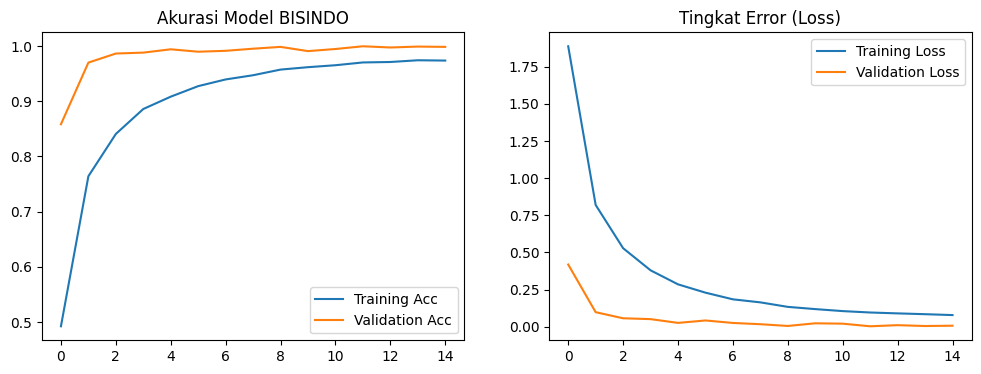

In [9]:
history = model.fit(
    train_generator,
    epochs=15,  # 15 Epoch cukup untuk transfer learning
    validation_data=val_generator
)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
plt.title('Akurasi Model BISINDO')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Tingkat Error (Loss)')
plt.legend()
plt.show()

Disini adalah tahap **"sekolah"** bagi model AI. model.fit menyuruh model melihat ribuan gambar tangan berulang-ulang sebanyak 15 kali putaran (epochs) untuk belajar membedakan A sampai Z. Setelah itu, kita memvisualisasikan rapor belajarnya menggunakan grafik. Hasilnya akurasi validasi (val_accuracy) naik drastis dari 85% di epoch 1 menjadi 99.8% di epoch 15. Grafik Loss (error) juga turun mendekati nol, menandakan model sangat paham dan tidak sekadar menghapal (tidak overfitting).

# **Simpan & Download Model 💾**

In [10]:
model.save('bisindo_smart_model.h5')
print("✅ Model .h5 tersimpan")

from google.colab import files
files.download('bisindo_smart_model.h5')

✅ Model .h5 tersimpan


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
model.save('bisindo_smart_model.keras')
print("✅ Model .keras tersimpan")

from google.colab import files
files.download('bisindo_smart_model.keras')

✅ Model .keras tersimpan


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
# Konversi Model ke TFLite
model = tf.keras.models.load_model('bisindo_smart_model.keras')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('bisindo_smart_model.tflite', 'wb') as f:
    f.write(tflite_model)
print("✅ Model berhasil dikompres jadi .tflite")

from google.colab import files
files.download('bisindo_smart_model.tflite')

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 47 variables whereas the saved optimizer has 92 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Saved artifact at '/tmp/tmpwn7e0ua6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  137696564662480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137699137687952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137699137688528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137699137687184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137699137686416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137699137686608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137699137686992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137699137686800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137699137686224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137699137683728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137699137688

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Langkah terakhir adalah **"membungkus"** otak yang sudah pintar tadi agar bisa dibawa pulang. Kita menyimpannya dalam 3 format: .h5 (format Keras lama yang kompatibel luas), .keras (format standar baru TensorFlow), dan .tflite (versi yang sudah dikompres/dioptimasi khusus untuk perangkat mobile atau web agar ringan). Ketiga file berhasil dibuat dan siap diunduh. File .tflite ini lah yang nanti akan menjadi kunci kecepatan aplikasi real-time kita di laptop atau web.